# Using MonoTools.fit with RVs

I don;t have a good example to hand, so let's use synthetic data.

First lets' import what we need:

In [1]:
from MonoTools.MonoTools import fit,tools,lightcurve

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo

##### The data
Let's create two fake TESS datasets with 30d observations and a 300d gap. 

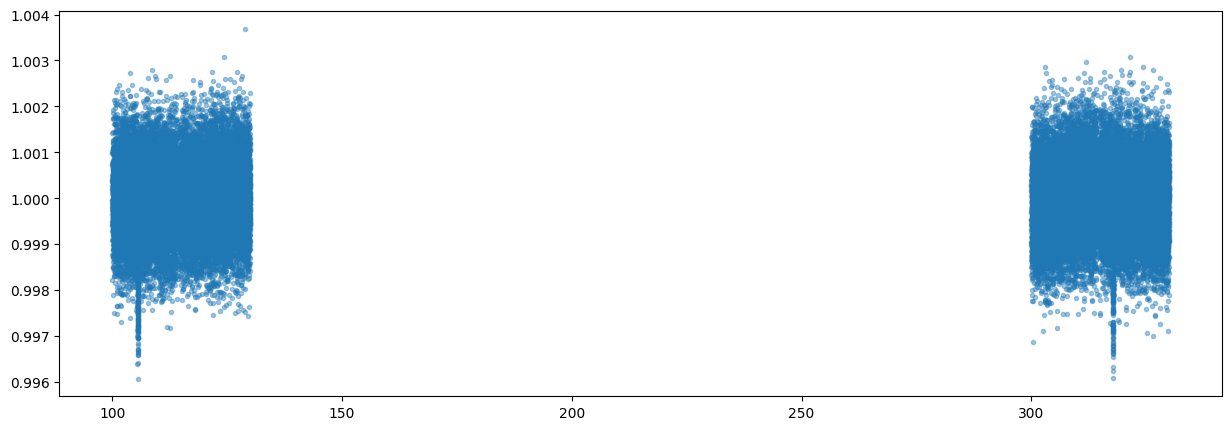

In [2]:
x = np.concatenate((np.arange(100,114.25,2/1440), np.arange(114.75,130,2/1440),
                    np.arange(300,314.25,2/1440), np.arange(314.75,330,2/1440)))

#Adding some randomised sinusoids to mimic stellar variability:
y_sv=abs(np.random.normal(0.0002,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(8,1)))+abs(np.random.normal(0.0001,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(3,0.8)))

#Now adding noise to the lightcurve
noise=0.0008
y = np.random.normal(1.0,noise,len(x))+y_sv
yerr = noise*1.1+np.zeros_like(y)

it0=105.57

#Depth here is a little over double the per-point scatter
idepth=0.0018

true_orbit = xo.orbits.KeplerianOrbit(period=35.36789, t0=it0, b=0.2, omega=0.72, ecc=0.025)
true_model = xo.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(orbit=true_orbit, t=x, r=np.sqrt(idepth)).eval()[:, 0]
y += true_model

#plotting the data:
plt.figure(figsize=(15,5))
plt.plot(x, y,'.',alpha=0.4);

#### Generating the fake RV data


In [3]:
#Taking 25 randomly-sampled RVs over a range starting 30d after the last orbit finished
x_rv=np.sort(360+80*np.random.random(25))

# Getting an RV with a semi-major axis
pure_rvs=true_orbit.get_radial_velocity(x_rv, K=10).eval()

#Adding 8.1m/s scatter, and jitter using a couple of sin functions
# - a) amplitude 6.5 and period of ~11d, b) 9m/s and period ~250
jitps=np.random.normal([11,250],[1.5,40])
jitt0s=np.random.random(2)*jitps
y_jitter= 6.5*np.sin(np.pi*2*(x_rv-jitt0s[0])/(jitps[0])) + 19*np.sin(np.pi*2*(x_rv-jitt0s[1])/(jitps[1]))
y_rv = np.random.normal(pure_rvs,np.tile(9,len(x_rv)))+y_jitter

#We'll assume the real RV errors mildly underestimate the true values
yerr_rv = np.random.normal(7.13,0.5,25)

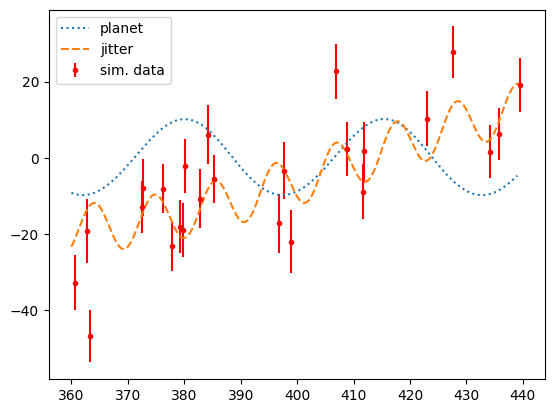

In [4]:
#plt.errorbar(x_rv,y_rv,yerr=yerr_rv,fmt='.')
plt.errorbar(x_rv,y_rv,yerr=yerr_rv,fmt='.r',label='sim. data')
plt.plot(np.arange(360,440,1),
         true_orbit.get_radial_velocity(np.arange(360,440,1), K=10).eval(),':',label='planet')
plt.plot(np.arange(360,440,0.1),
         6.5*np.sin(np.pi*2*(np.arange(360,440,0.1)-jitt0s[0])/(jitps[0])) + 19*np.sin(np.pi*2*(np.arange(360,440,0.1)-jitt0s[1])/(jitps[1])),'--',label='jitter')
plt.legend()

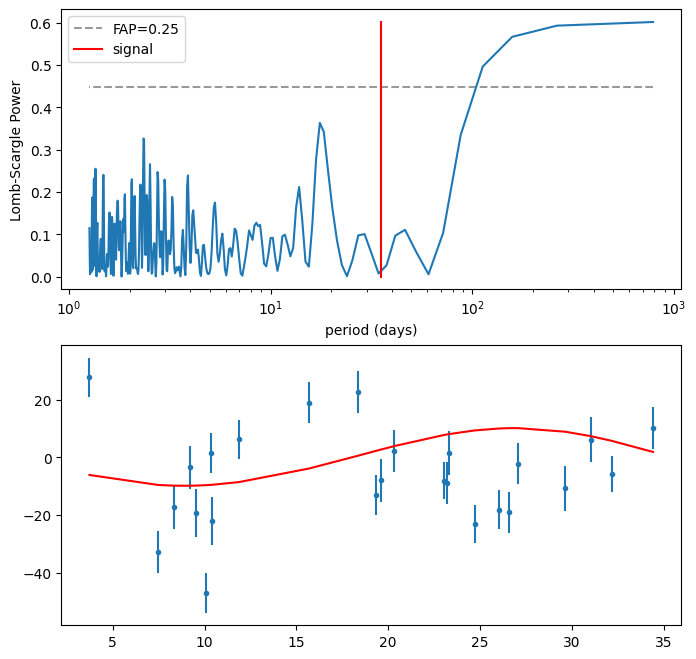

In [5]:
#Doing a lomb-scargle periodogram from scipy:
from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv, yerr_rv)
freq, power = ls.autopower()
fapthresh=0.25
faplevel=ls.false_alarm_level(fapthresh)
#periods = np.linspace(2, 240, 4000)
#ang_freqs = 2 * np.pi / periods
#power = scipy.signal.lombscargle(x_rv, y_rv, ang_freqs)

# plot the results
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(1/freq,np.tile(faplevel,len(freq)),'--k',alpha=0.4,label='FAP='+str(fapthresh))
plt.plot(1/freq, power)
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.xscale('log')
plt.plot([35.36789,35.36789],[0,np.max(power)],'-r',label='signal')
plt.legend()

plt.subplot(212)
p=35.36789
phase=(x_rv-it0)%p
plt.errorbar(phase,y_rv,yerr=yerr_rv,fmt='.')
plt.plot(np.sort(phase),pure_rvs[np.argsort(phase)],'-r')

Ok, that looks passable. Whatever peak is there is not particularly high or well-resolved. The _raw_ SNR (i.e. ignoring the jitter and trend) is less than 6 ($10/9*\sqrt{25}$ =5.55). This is not going to be easy, but let's see how our model performs...

First we need to initialise the model. We can compile our x, y, yerr, etc into a dictionary. Let's also assume solar-like parameters

In [6]:
lc=lightcurve.lc()
lc.load_lc(time=x,
           fluxes={'flux':1000*(y-1)},
           flux_errs={'flux_err':yerr*1000},
           flx_system='ppt',jd_base=2457000,
           mission='tess',sect='100',src='test')
mlc=lightcurve.multilc(9999999999,'tess',do_search=False,load=False)
mlc.stack([lc])

In [7]:
from astropy.coordinates import SkyCoord
from astropy import units as u

mod=fit.monoModel(999999999,'tess',lc=mlc,radec=SkyCoord(0.0*u.deg,0.0*u.deg))
mod.init_starpars(Rstar=[1.0,0.05,0.05],
                  rhostar=[1.0,0.1,0.1],
                  Teff=[5700,120,120])

#### Adding RVs to the model

Here we need to add a dictionary with `'time'`, `'rv'`, `'rv_err'`, `'jd_base'` (though this can be left out if the RVs are in the same time format as the lightcurve), and `'rv_unit'` (which defaults to assuming m/s).

For the moment the model only works assuming a single telescope (i.e. it does not compute e.g. inter-instrument offsets). 

We can also specify here the complexity of the polynomial we want to include to fit RV trends - let's use a linear trend, i.e. n_poly_trend=2, which is the default.

In [8]:
mod.add_rvs({'time':x_rv, 'rv':y_rv, 'rv_err':yerr_rv, 'jd_base':2457000, 'rv_unit':'ms'}, n_poly_trend=2)

Assuming all one telescope (HARPS).


In [9]:
#mod.add_duo({'tcen':105.57,'tcen_2':244.53,'tdur':0.21,'depth':idepth},'00')
#mod.add_multi({'tcen':105.57,'period':17.36789,'period_err':0.0025,'tdur':0.21,'depth':5e-3,'b':0.25},'00')
mod.add_duo({'tcen':105.57,'tcen_2':317.78,'tdur':0.275,'depth':idepth},'00')

Initialising the model. There is once again a long list of potential inputs as can be seen on the `FitExample.ipynb` notebook. 

One extra to be aware of here is:

- derive_k - bool - If we have RVs, do we derive K for each alias or fit for a single K param?

The default here is that we _derive_ a semi-amplitude for each model step. This works by using the model parameters to generate a normalised rv and then performing linear least-squares to get the amplitude. The alternative - fitting for a single global semi-amplitude - _is_ possible with MonoTools.fit, but it tends not to be a good idea as it might get "stuck" at small values in the wrong aliases.

In [10]:
mod.init_model(use_GP=False, debug=True)

1 planets | monos: [] multis: [] duos: ['00'] use GP= False
2970 points in new lightcurve, compared to  42478  in original mask, leaving  2970 points in the lc
initialised priors
Forming Pymc3 model with: monos: [] multis: [] duos: ['00'] trios: []
initialised planet info
[-0.26566554] 5078 / 5606
ts
min_eccs[pl] __str__ = [0.45996769 0.26010521 0.13032083 0.03515769 0.03918892 0.09965102
 0.15022088 0.19340961]
omegas[pl] __str__ = [1.57079633 1.57079633 1.57079633 1.57079633 4.71238898 4.71238898
 4.71238898 4.71238898]
bs[pl] __str__ = 0.2874938335288231
t0s[pl] __str__ = 105.57
pers[pl] __str__ = [212.21       106.105       70.73666667  53.0525      42.442
  35.36833333  30.31571429  26.52625   ]
sinfs __str__ = [[ 0.82046743  0.36517722 -0.49831726 -0.95706082 -0.05401535 -0.90866206
  -0.66775872  0.85647685]
 [ 0.79311211  0.29219405 -0.62214511 -0.8545232  -0.33103775 -0.99705346
  -0.16147489  0.99966812]
 [ 0.78590077  0.27302579 -0.65278998 -0.81812778 -0.40017322 -0.9998014

pers __str__ = [212.21       106.105       70.73666667  53.0525      42.442
  35.36833333  30.31571429  26.52625   ]
Ks __str__ = [16.52116161  0.05        0.05        0.05        6.17844108  1.98107895
  2.98488146  0.05      ]
Ks __str__ = [8]
model_rvs[pl] __str__ = [25  8]
Intiialised everything. Optimizing
optimizing model {'logrho_S_interval__': array(0.69314718), 'Rs': array([1.]), 't0_00_interval__': array(0.), 't0_2_00_interval__': array(0.), 'logror_00_interval__': array(0.74809916), 'b_00_impact__': array(-0.96542703), 'tdur_00_interval__': array(-1.09362475), 'u_star_tess_interval__': array([-0.52639836, -1.27153906]), 'logs2': array([-1.26566554]), 'rv_offsets': array([-6.40563437]), 'rv_polys': array(0.), 'rv_logs2': array(0.5), 'phot_mean': array(-0.02620878)}
before logrho_S_interval__          2.08
Rs                           2.08
t0_00_interval__             0.87
t0_2_00_interval__           1.29
logror_00_interval__        -0.45
b_00_impact__               -1.61
tdu


before logrho_S_interval__          2.08
Rs                           2.08
t0_00_interval__             0.87
t0_2_00_interval__           1.29
logror_00_interval__        -0.45
b_00_impact__               -1.61
tdur_00_interval__          -0.22
u_star_tess_interval__      -0.45
logs2                       -1.61
rv_offsets                  -1.28
rv_polys                    -1.43
rv_logs2                    -1.86
phot_mean                   -1.35
margrvloglik              -126.30
marglcloglik             -4876.07
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [tdur_00, logror_00, logs2]


message: Optimization terminated successfully.
logp: -7548.020150906381 -> -6022.4775026052785
optimizing logp for variables: [t0_2_00, t0_00, logror_00, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -6022.477502605278 -> -6021.367755712544
optimizing logp for variables: [phot_mean, logrho_S, Rs, rv_logs2, rv_polys, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -6021.367755712545 -> -5301.311316193947
optimizing logp for variables: [tdur_00, b_00, logror_00, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -5301.311316193947 -> -5301.311316193947
optimizing logp for variables: [u_star_tess, logrho_S, Rs, logs2, phot_mean, rv_logs2, rv_polys, t0_2_00, t0_00, logror_00]


message: Desired error not necessarily achieved due to precision loss.
logp: -5301.311316193947 -> -5301.311316193947
optimizing logp for variables: [phot_mean, rv_logs2, rv_polys, rv_offsets, logs2, u_star_tess, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: -5301.311316193947 -> -5301.311316193947
optimizing logp for variables: [tdur_00, logror_00, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -5301.311316193947 -> -5301.311316193947


after logrho_S_interval__          2.08
Rs                           2.08
t0_00_interval__             0.87
t0_2_00_interval__           1.29
logror_00_interval__        -0.45
b_00_impact__               -1.61
tdur_00_interval__          -0.22
u_star_tess_interval__      -0.45
logs2                       -1.61
rv_offsets                  -1.28
rv_polys                    -1.43
rv_logs2                    -1.86
phot_mean                   -1.35
margrvloglik              -126.30
marglcloglik             -4876.07
Name: Log-probability of test_point, dtype: float64


### Plotting best-fit

Ok, here we can plot the best-fit photometry and RVs. We can choose either to plot all the aliases, or to simply plot the best N aliases (based on marginalised probabilities).

The plots here have alpha sorted by logprob, so the worst RV curves are somewhat hard to see. But the best one looks good!

/Volumes/LUVOIR/MonoToolsData/TIC00999999999/TIC00999999999*model.pickle
[] []
[]


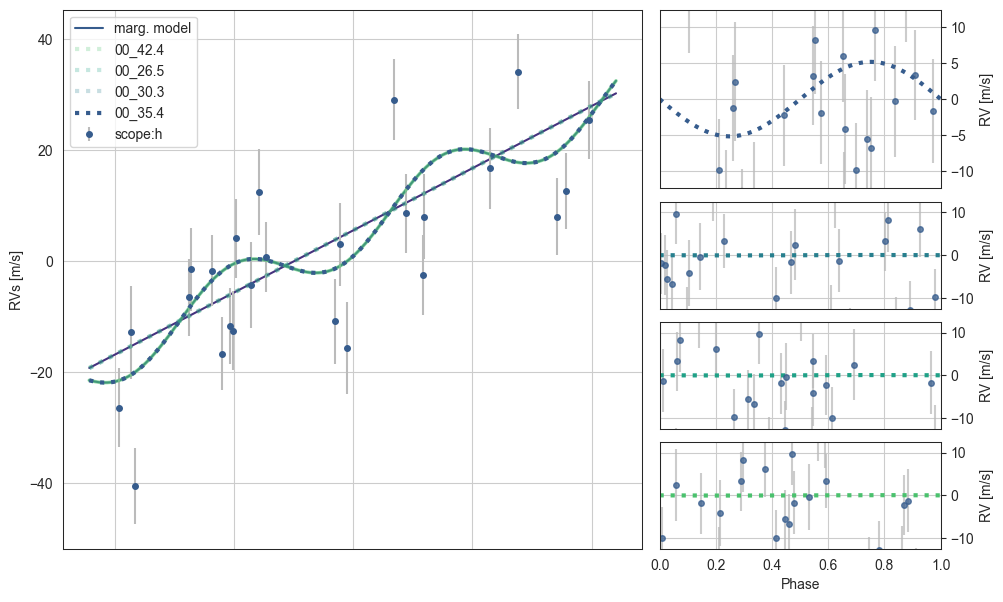

In [11]:
#mod.Plot(n_samp=1)
mod.PlotRVs(plot_alias='best', nbest=4, n_samp=1)

initialising transit
Initalising Transit models for plotting with n_samp= 10


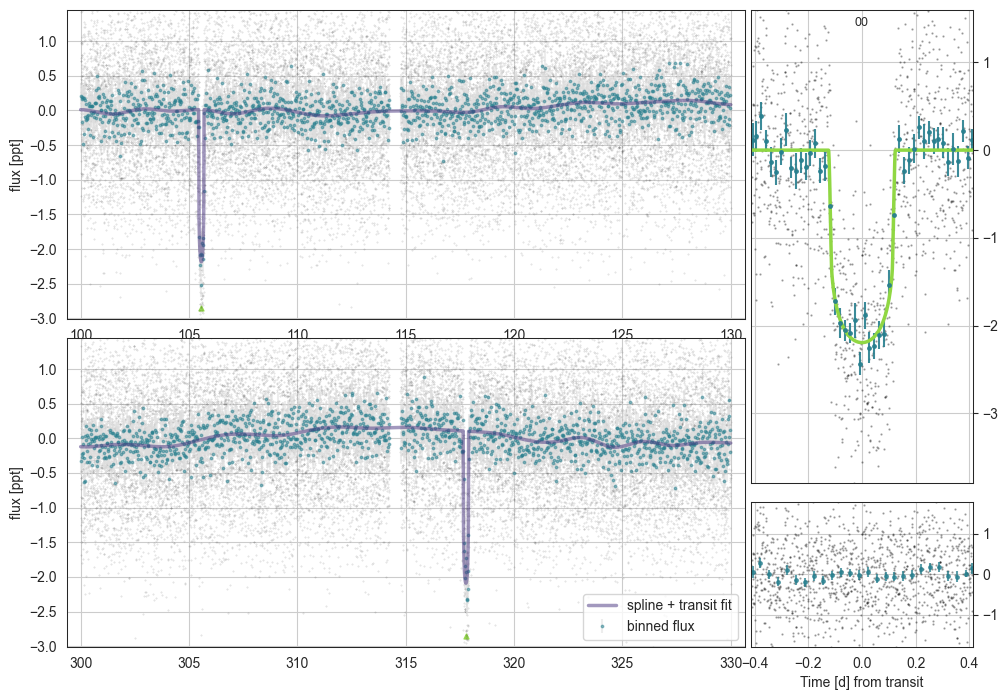

In [12]:
mod.Plot()

The looks good! Let's run the MCMC

In [15]:
mod.SampleModel(n_chains=1)

<class 'dict'>
dict_keys(['logrho_S_interval__', 'Rs', 't0_00_interval__', 't0_2_00_interval__', 'logror_00_interval__', 'b_00_impact__', 'tdur_00_interval__', 'u_star_tess_interval__', 'logs2', 'rv_offsets', 'rv_polys', 'rv_logs2', 'phot_mean', 'logrho_S', 'rho_S', 'Ms', 't0_00', 't0_2_00', 'per_00', 'logror_00', 'ror_00', 'rpl_00', 'logmassest_00', 'b_00', 'tdur_00', 'vel_00', 'logvel_00', 'min_ecc_00', 'omega_00', 'a_Rs_00', 'incl_00', 'u_star_tess', 'rv_trend', '00_light_curves', 'nonmarg_rvs', 'K_00', 'model_rv_00', 'Mp_00', 'rho_00', 'per_prior_00', 'max_ecc_00', 'v_prior_00', 'logprior_00', 'logmass_sd_00', 'rv_loglik_00', 'logprob_00', 'logprob_marg_00', 'ecc_00', 'ecc_marg_00', 'vel_marg_00', 'per_marg_00', 'marg_rv_model_00', 'K_marg_00', 'Mp_marg_00', 'rho_marg_00', 'marg_all_lc_model', 'marg_all_rv_model'])


Sequential sampling (1 chains in 1 job)
NUTS: [phot_mean, rv_logs2, rv_polys, rv_offsets, logs2, u_star_tess, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]


Sampling 1 chain for 330 tune and 500 draw iterations (330 + 500 draws total) took 79 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Saving sampled model parameters to file with shape:  (154, 14)


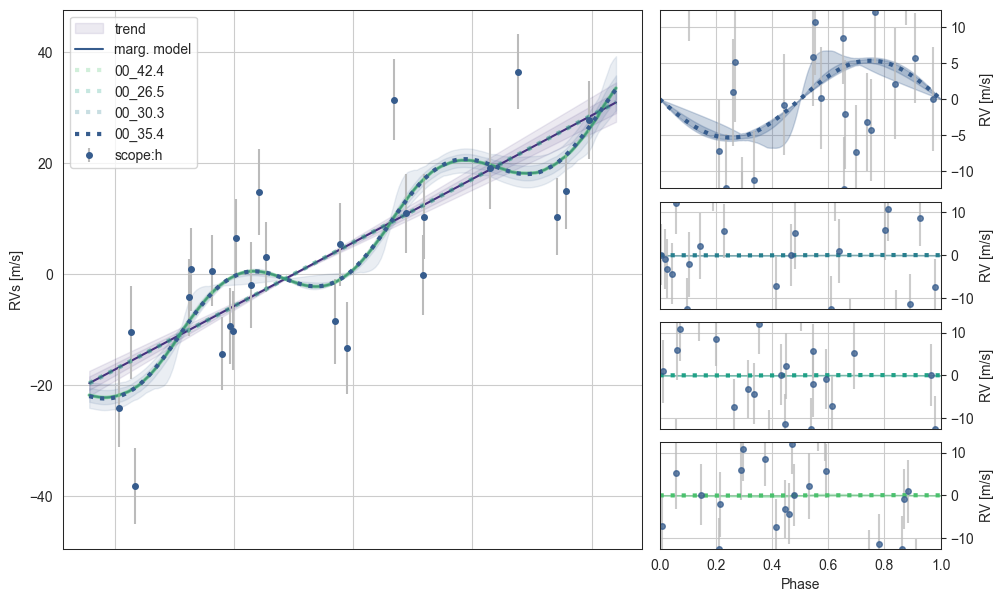

In [17]:
mod.PlotRVs(n_samp=120)

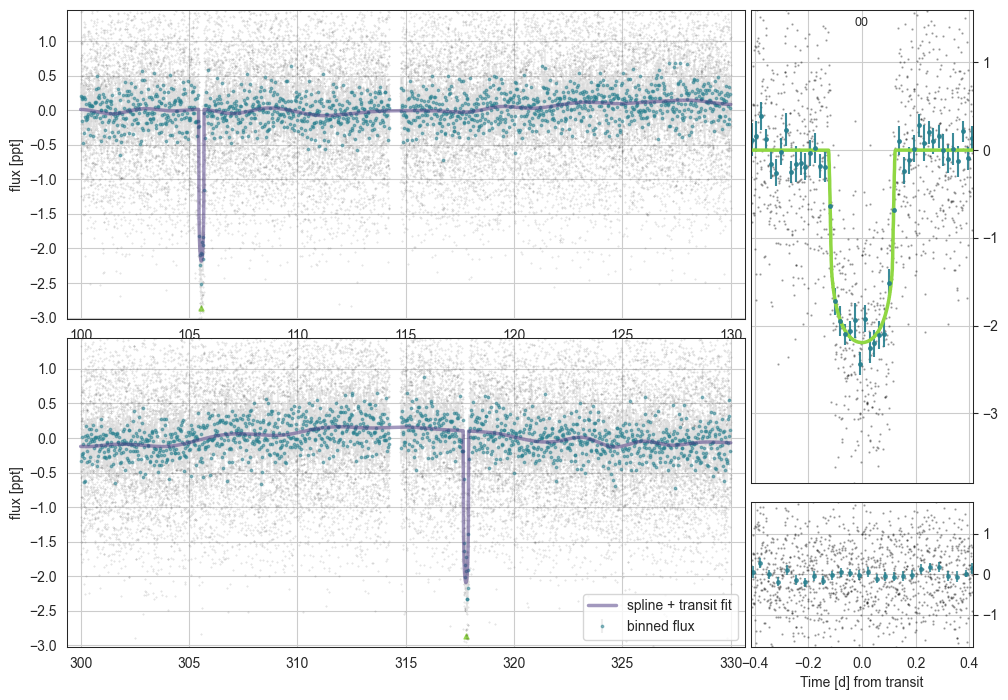

In [18]:
mod.Plot(n_samp=120)

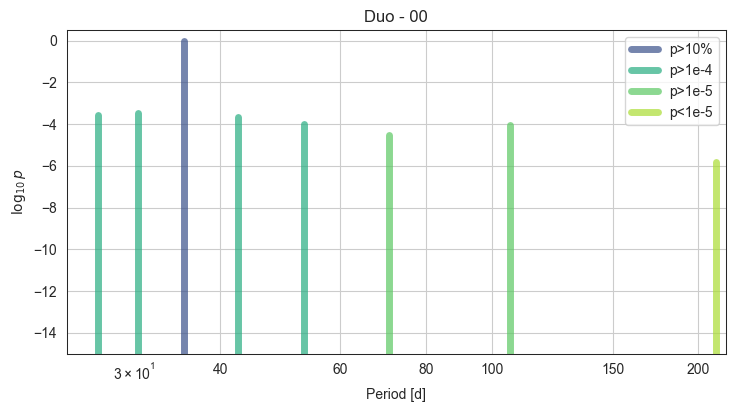

In [19]:
mod.PlotPeriods()

In [20]:
{str(mod.planets['00']['period_aliases'][n_alias])[:6]:np.exp(np.nanmedian(mod.trace['logprob_marg_00'][:,n_alias])) for n_alias in np.arange(mod.planets['00']['npers'])[::-1]}

{'26.526': 0.00020045967627815587,
 '30.315': 0.00021571054358774045,
 '35.368': 0.999247090670854,
 '42.441': 0.00012701004270871438,
 '53.052': 5.297062990967473e-05,
 '70.736': 2.1216392619315546e-05,
 '106.10': 1.353382706755048e-05,
 '212.20': 2.625207221525294e-07}

We have recovered the correct alias at pretty high confidence (99.63%)! Impressive

In [32]:
mod.PlotCorner(corner_vars=['logrho_S', 'logror_00', 'b_00', 'tdur_00', 't0_00', 't0_2_00', 'per_marg_00', 'ecc_marg_00', 'K_marg_00'])
#()